# Baseline Modelle

In [1]:
#Laden der benötigten Bibliotheken
import pandas as pd
import numpy as np
import nltk   #Natural Language ToolKit
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Daten einlesen


In [7]:
data_apple = pd.read_csv("")

In [9]:
data_apple["firm_id"] = 1

In [11]:
data_biontech = pd.read_csv("")

In [12]:
data_biontech["firm_id"] = 2

In [139]:
data_biontech["basic_sentiment"].value_counts()

0.0    3833
1.0     147
Name: basic_sentiment, dtype: int64

In [13]:
data = data_apple.append(data_biontech, ignore_index = True )

In [14]:
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment,firm_id
0,2021-12-31 23:57:27+00:00,422497650,hoyasaxa1978,hoyasaxa1978,819540,"$AAPL 🍏 In the “final second” of the Close, 8...",0.0,1
1,2021-12-31 23:51:08+00:00,422496711,InsiderFinance,InsiderFinance_io,4012623,Sweep Options Activity: $AAPL is the #1 ticker...,NaN,1
2,2021-12-31 23:48:33+00:00,422496310,OptionsQueenTrader,Malika,5498543,$SPY next year we will go low real low. Expect...,1.0,1
3,2021-12-31 23:47:55+00:00,422496202,BigdaddyRoy,Big Daddy,3830233,$AAPL someone told me Apple will announce Appl...,NaN,1
4,2021-12-31 23:44:31+00:00,422495691,hoangkc,Khanh Hoang,1553292,"The weekly #rrgchart of $AAPL, $AMZN, and $GOOGL",NaN,1


## Pre-Processing

In [4]:
#lower case
#data["tweets_preproc"] = data["body"].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [18]:
#html tags und urls raus
from bs4 import BeautifulSoup
data["tweets_preproc"]=data["body"].apply(lambda x: BeautifulSoup(x).get_text())
import re
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(r"http\S+", "", x))

In [6]:
#kontrahieren: don't -> do not etc.
#def contractions(s):
# s = re.sub(r"won’t", "will not",s)
# s = re.sub(r"would’t", "would not",s)
# s = re.sub(r"could’t", "could not",s)
# s = re.sub(r"\’d", " would",s)
# s = re.sub(r"can\’t", "can not",s)
# s = re.sub(r"n\’t", " not", s)
# s= re.sub(r"\’re", " are", s)
# s = re.sub(r"\’s", " is", s)
# s = re.sub(r"\’ll", " will", s)
# s = re.sub(r"\’t", " not", s)
# s = re.sub(r"\’ve", " have", s)
# s = re.sub(r"\’m", " am", s)
# return s
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x:contractions(x))

In [19]:
#sonderzeichen etc. raus
#Ressourcen downloaden
#nltk.download('punkt')
#sonderzeichen etc. raus
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [20]:
#überschüssige leerzeichen raus
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(' +', ' ', x))

In [9]:
#fehlende Ressourcen downloaden
#nltk.download('stopwords')
#stopwords raus
#from nltk.corpus import stopwords
#stop = stopwords.words('english')
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

In [10]:
#lemmatization
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [21]:
#Datumsvariable erstellen - um ggf. spaeter Ergebnisse zu plotten
data["created_at"] = pd.to_datetime(data.created_at, format='%Y-%m-%d %H:%M:%S')
data['date'] = data['created_at'].dt.strftime('%m/%d/%Y')

In [22]:
#Prüfen, ob alles geklappt hat
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment,firm_id,tweets_preproc,date
0,2021-12-31 23:57:27+00:00,422497650,hoyasaxa1978,hoyasaxa1978,819540,"$AAPL 🍏 In the “final second” of the Close, 8...",0.0,1,AAPL In the final second of the Close Million...,12/31/2021
1,2021-12-31 23:51:08+00:00,422496711,InsiderFinance,InsiderFinance_io,4012623,Sweep Options Activity: $AAPL is the #1 ticker...,NaN,1,Sweep Options Activity AAPL is the ticker with...,12/31/2021
2,2021-12-31 23:48:33+00:00,422496310,OptionsQueenTrader,Malika,5498543,$SPY next year we will go low real low. Expect...,1.0,1,SPY next year we will go low real low Expect ...,12/31/2021
3,2021-12-31 23:47:55+00:00,422496202,BigdaddyRoy,Big Daddy,3830233,$AAPL someone told me Apple will announce Appl...,NaN,1,AAPL someone told me Apple will announce Appl...,12/31/2021
4,2021-12-31 23:44:31+00:00,422495691,hoangkc,Khanh Hoang,1553292,"The weekly #rrgchart of $AAPL, $AMZN, and $GOOGL",NaN,1,The weekly rrgchart of AAPL AMZN and GOOGL,12/31/2021


In [26]:
#Datensatz nur mit gelabelten Tweets
data_labeled = data.dropna(subset = ["basic_sentiment"])

In [ ]:
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)

In [27]:
#nicht gelabelte Tweets für spätere Anwendungen
data_unlabeled = data[data["basic_sentiment"].isnull()]

## Sentiment Analysis

### 1 - VADER

Vorteile:
- Braucht kein Training
- Funktioniert ohne gelabelte Daten
- speziell für Social Media (unterscheidet z.B. TOLL - toll - toll!)

Nachteile:
- Liefert teilweise keine optimalen Ergebnisse
- Hat drei Klassen (neg/neutr/pos), Tweets haben nur zwei

In [69]:
#download vader lexikon (scheint in nltk zu fehlen (vllt. auch Problem mit anderem vader?))
#nltk.download('vader_lexicon')
#nltk vader
sid = SentimentIntensityAnalyzer()
#model
data_labeled.loc[:,"v_scores"] = data_labeled["tweets_preproc"].apply(lambda body: sid.polarity_scores(body))

C:\Anaconda3\envs\NLPCourse\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [70]:
#eigene Spalte für scores erstellen
data_labeled.loc[:,'compound']  = data_labeled['v_scores'].apply(lambda score_dict: score_dict['compound'])

In [71]:
#Predictions
data_labeled.loc[:,'v_sentiment'] = (
    np.where(
        data_labeled['compound'] > 0.05,0,
        np.where(data_labeled['compound'] < -0.05, 1, -99)))

In [72]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(data_labeled["basic_sentiment"], data_labeled["v_sentiment"])

array([[    0,     0,     0],
       [18903,  2160,   357],
       [ 6725,   734,   127]], dtype=int64)

In [73]:
data_labeled["v_sentiment"].value_counts()

-99    25628
 0      2894
 1       484
Name: v_sentiment, dtype: int64

### 2 - TF - IDF

Term-frequency - inverse document-frequency: $tf-idf(t,d) = tf(t,d) * idf(t)$ </br>
tf = Anzahl eines Wortes $t$ in einem Tweet/Dokument </br>
$idf(t) = log\frac{n}{1+df(t)}$ (sklearn weicht leicht von Standardformulierung ab)</br>
mit $n$ = Anzahl aller Tweets im Datensatz, $df(t)$ = Anzahl aller Tweets, die Wort $t$ enthalten. </br>
Tf-idf wird zusätzlich normalisiert: </br>
$v_{norm} = \frac{v}{||v||_{2}} = \frac{v}{\sqrt{v_{1}² + v_{2}² + ... + v_{n}²}}$ </br>

In [44]:
#train / test split mit gleichen Anteilen der Klassen in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
baseline_train,baseline_test = train_test_split(data_labeled,
                                                  stratify = data_labeled["basic_sentiment"],
                                                  test_size=0.25, random_state=42)
print("Training Set: ",baseline_train.shape, "Test Set: ",baseline_test.shape)

Training Set:  (21754, 13) Test Set:  (7252, 13)


In [49]:
baseline_train["basic_sentiment"].value_counts()

0.0    16065
1.0     5689
Name: basic_sentiment, dtype: int64

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
#Anwendung auf Training- und Testdaten
tf_x_train = vectorizer.fit_transform(baseline_train["tweets_preproc"])
tf_x_test = vectorizer.transform(baseline_test["tweets_preproc"])

In [46]:
tf_x_train

<21754x16775 sparse matrix of type '<class 'numpy.float64'>'
	with 307182 stored elements in Compressed Sparse Row format>

In [22]:
#pd.DataFrame.sparse.from_spmatrix(tf_x_train)

In [47]:
tf_x_test

<7252x16775 sparse matrix of type '<class 'numpy.float64'>'
	with 100217 stored elements in Compressed Sparse Row format>

In [50]:
#SVM classifier
#ohne grid search
from sklearn import svm
svm = svm.SVC(class_weight={1:73.8, 0:26.2})

In [51]:
#fitten
svm.fit(tf_x_train, baseline_train["basic_sentiment"])

SVC(class_weight={0: 26.2, 1: 73.8})

In [52]:
#predictions
y_fit_svm_base = svm.predict(tf_x_test)

In [53]:
#ergebnisse /modellgüte
from sklearn.metrics import classification_report
svm_results_base = classification_report(baseline_test["basic_sentiment"], y_fit_svm_base, output_dict = True)

In [54]:
svm_results_base

{'0.0': {'precision': 0.8564064801178203,
  'recall': 0.8687208216619982,
  'f1-score': 0.8625196996384535,
  'support': 5355},
 '1.0': {'precision': 0.6137362637362638,
  'recall': 0.5888244596731682,
  'f1-score': 0.6010223298358892,
  'support': 1897},
 'accuracy': 0.7955046883618312,
 'macro avg': {'precision': 0.7350713719270421,
  'recall': 0.7287726406675832,
  'f1-score': 0.7317710147371714,
  'support': 7252},
 'weighted avg': {'precision': 0.7929280740952317,
  'recall': 0.7955046883618312,
  'f1-score': 0.7941164301244623,
  'support': 7252}}

In [55]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': np.logspace(-3, 2, 6), 'kernel': ['linear']},
  {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': ['rbf']},
 ]

grid_search = GridSearchCV(svm, param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(tf_x_train, baseline_train["basic_sentiment"])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=SVC(class_weight={0: 26.2, 1: 73.8}), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['rbf']}],
             verbose=2)

In [56]:
print(grid_search.best_params_)

{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}


In [57]:
#Bestes Modell auf Testdaten anwenden und fitted values speichern
model_svm = grid_search.best_estimator_
y_fit_svm = model_svm.predict(tf_x_test)
baseline_test["sentiment_svm"] = y_fit_svm

In [58]:
#ergebnisse /modellgüte
svm_results=classification_report(baseline_test["basic_sentiment"], y_fit_svm,output_dict=True)

In [59]:
svm_results

{'0.0': {'precision': 0.8585914454277286,
  'recall': 0.8696545284780579,
  'f1-score': 0.8640875776973745,
  'support': 5355},
 '1.0': {'precision': 0.6181619256017505,
  'recall': 0.595677385345282,
  'f1-score': 0.6067114093959731,
  'support': 1897},
 'accuracy': 0.7979867622724766,
 'macro avg': {'precision': 0.7383766855147396,
  'recall': 0.73266595691167,
  'f1-score': 0.7353994935466739,
  'support': 7252},
 'weighted avg': {'precision': 0.7956991675581918,
  'recall': 0.7979867622724766,
  'f1-score': 0.7967623444833979,
  'support': 7252}}

   precision = tp / (tp + fp) </br>
   recall / sensitivity = tp / (tp + fn) </br>
   F1 = 2 * (precision * recall) / (precision + recall)

In [62]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Base model
rf = RandomForestClassifier(random_state = 42, class_weight={1:73.8, 0:26.2})

In [63]:
#fit base model
rf.fit(tf_x_train, baseline_train["basic_sentiment"])

RandomForestClassifier(class_weight={0: 26.2, 1: 73.8}, random_state=42)

In [65]:
#predictions
y_fit_rf_base = rf.predict(tf_x_test)
baseline_test["sentiment_rf"] = y_fit_rf_base

In [67]:
#ergebnisse /modellgüte
rf_results=classification_report(baseline_test["basic_sentiment"], y_fit_rf_base,output_dict=True)

In [68]:
rf_results

{'0.0': {'precision': 0.8203349687024192,
  'recall': 0.9055088702147526,
  'f1-score': 0.8608201668737795,
  'support': 5355},
 '1.0': {'precision': 0.6226696495152871,
  'recall': 0.4401686874011597,
  'f1-score': 0.515750463248919,
  'support': 1897},
 'accuracy': 0.7837837837837838,
 'macro avg': {'precision': 0.7215023091088532,
  'recall': 0.6728387788079562,
  'f1-score': 0.6882853150613493,
  'support': 7252},
 'weighted avg': {'precision': 0.7686290792239319,
  'recall': 0.7837837837837838,
  'f1-score': 0.7705557945935312,
  'support': 7252}}

In [ ]:
#grid search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid_search_rf = GridSearchCV(rf, param_grid_rf, n_jobs = -1, verbose = 2)
grid_search_rf.fit(tf_x_train, baseline_train["basic_sentiment"])

In [ ]:
#Bestes Modell auf Testdaten anwenden und fitted values speichern
model_rf = grid_search_rf.best_estimator_
y_fit_rf = model_rf.predict(tf_x_test)
baseline_test["sentiment_rf"] = y_fit_rf

### Zusammenfassung:

    VADER: funtkioniert nicht gut
    TF_IDF: liefert für positive Tweets gute Ergebnisse; negative Tweets werden nicht gut erkannt

ToDo: </br>
pre-processing korrekt? </br>
Ergebnisse schöner darstellen




## Ergebnisse plotten

kurzer Versuch, die Predictions zu aggregieren, daraus einen Sentiment Score für einen Tag zu berechnen und diesen zu plotten

In [95]:
baseline_test["basic_sentiment_apple"] = (np.where((baseline_test["basic_sentiment"] == 0) & (baseline_test["firm_id"] == 1),0,
                                                   np.where((baseline_test["basic_sentiment"] == 1) & (baseline_test["firm_id"] == 1),1,-99)))

In [97]:
baseline_test["basic_sentiment_biontech"] = (np.where((baseline_test["basic_sentiment"] == 0) & (baseline_test["firm_id"] == 2),0,
                                                   np.where((baseline_test["basic_sentiment"] == 1) & (baseline_test["firm_id"] == 2),1,-99)))

In [98]:
baseline_test["sentiment_svm_apple"] = (np.where((baseline_test["sentiment_svm"] == 0) & (baseline_test["firm_id"] == 1),0,
                                                   np.where((baseline_test["sentiment_svm"] == 1) & (baseline_test["firm_id"] == 1),1,-99)))

In [99]:
baseline_test["sentiment_svm_biontech"] = (np.where((baseline_test["sentiment_svm"] == 0) & (baseline_test["firm_id"] == 2),0,
                                                   np.where((baseline_test["sentiment_svm"] == 1) & (baseline_test["firm_id"] == 2),1,-99)))

In [100]:
#function to create dummy variables and add them to the dataframe
def dummies(dataframe, columns):
    dummy_df = pd.get_dummies(data = dataframe, columns = columns, dtype = np.float64)
    return dummy_df

In [101]:
dummy_vars = ['basic_sentiment_apple','basic_sentiment_biontech','sentiment_svm_apple', "sentiment_svm_biontech"]
baseline_test = dummies(baseline_test, dummy_vars)

In [49]:
#aggregation
sentiment_scores_train = baseline_train.groupby("date").agg({'basic_sentiment_-1': sum,
                                                      'basic_sentiment_1': sum}) 

In [134]:
#aggregation
sentiment_scores_test = baseline_test.groupby("date").agg({'basic_sentiment_apple_0': sum,
                                                            'basic_sentiment_apple_1': sum,
                                                           'basic_sentiment_biontech_0': sum,
                                                            'basic_sentiment_biontech_1': sum,
                                                            'sentiment_svm_apple_0': sum,
                                                           'sentiment_svm_apple_1':sum,
                                                           'sentiment_svm_biontech_0':sum,
                                                           'sentiment_svm_biontech_1':sum}) 

In [118]:
def sentiment_score(pos,neg):
    avg_score = (pos - neg) / (pos + neg)
    return avg_score

In [135]:
sentiment_scores_test["basic_apple"] = sentiment_score(sentiment_scores_test["basic_sentiment_apple_0"], sentiment_scores_test["basic_sentiment_apple_1"])
sentiment_scores_test["basic_biontech"] = sentiment_score(sentiment_scores_test["basic_sentiment_biontech_0"], sentiment_scores_test["basic_sentiment_biontech_1"])
sentiment_scores_test["svm_apple"] = sentiment_score(sentiment_scores_test["sentiment_svm_apple_0"], sentiment_scores_test["sentiment_svm_apple_1"])
sentiment_scores_test["svm_biontech"] = sentiment_score(sentiment_scores_test["sentiment_svm_biontech_0"], sentiment_scores_test["sentiment_svm_biontech_1"])

In [136]:
#create date variable from index
sentiment_scores_test["date"] = sentiment_scores_test.index

In [137]:
sentiment_scores_test["date"] = pd.to_datetime(sentiment_scores_test.date, format='%m/%d/%Y')

In [138]:
sentiment_scores_test

,basic_sentiment_apple_0,basic_sentiment_apple_1,basic_sentiment_biontech_0,basic_sentiment_biontech_1,sentiment_svm_apple_0,sentiment_svm_apple_1,sentiment_svm_biontech_0,sentiment_svm_biontech_1,basic_apple,basic_biontech,svm_apple,svm_biontech,date
date,,,,,,,,,,,,,
12/01/2021,310.0,101.0,53.0,1.0,293.0,118.0,54.0,0.0,0.508516,0.962963,0.425791,1.000000,2021-12-01
12/02/2021,256.0,111.0,55.0,2.0,270.0,97.0,57.0,0.0,0.395095,0.929825,0.471390,1.000000,2021-12-02
12/03/2021,101.0,43.0,57.0,5.0,102.0,42.0,62.0,0.0,0.402778,0.838710,0.416667,1.000000,2021-12-03
12/04/2021,11.0,6.0,10.0,0.0,11.0,6.0,10.0,0.0,0.294118,1.000000,0.294118,1.000000,2021-12-04
12/05/2021,7.0,4.0,10.0,0.0,9.0,2.0,10.0,0.0,0.272727,1.000000,0.636364,1.000000,2021-12-05
12/06/2021,123.0,36.0,61.0,3.0,124.0,35.0,64.0,0.0,0.547170,0.906250,0.559748,1.000000,2021-12-06
12/07/2021,290.0,56.0,56.0,5.0,260.0,86.0,61.0,0.0,0.676301,0.836066,0.502890,1.000000,2021-12-07
12/08/2021,366.0,150.0,76.0,1.0,360.0,156.0,77.0,0.0,0.418605,0.974026,0.395349,1.000000,2021-12-08
12/09/2021,245.0,171.0,34.0,1.0,273.0,143.0,35.0,0.0,0.177885,0.942857,0.312500,1.000000,2021-12-09


In [123]:
#plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
%matplotlib inline

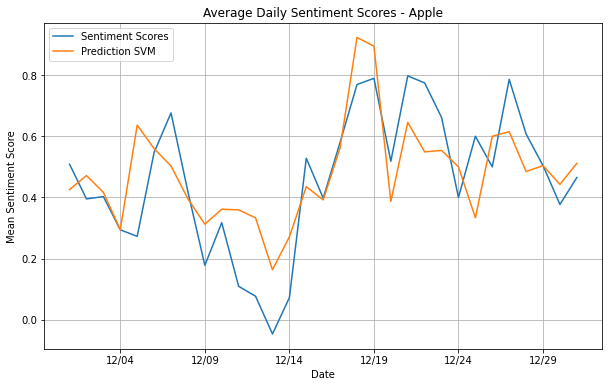

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic_apple, label = 'Sentiment Scores')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["svm_apple"], label = 'Prediction SVM')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Apple')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

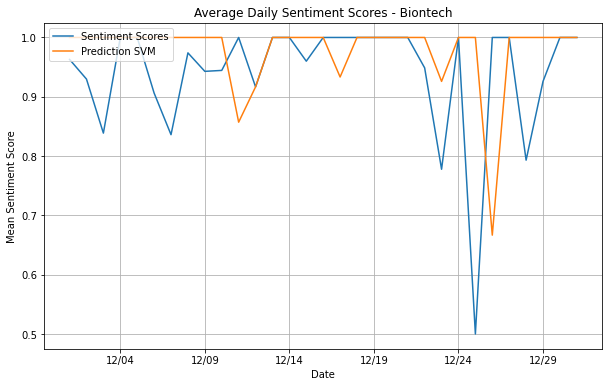

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic_biontech, label = 'Sentiment Scores')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["svm_biontech"], label = 'Prediction SVM')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Biontech')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())